# Inference on Hong Kong data of the Reproduction Number trajectory

In this note book, we aim to infer a realistic time profile of the reproduction numbers Rt, using local and imported cases from the region of Hong Kong, China. The data spans from 23 Jan 2020 - 24 Mar 2020. For this analysis we assume that local and imported cases are equally as likely to likely to spread the virus within the community. This means that the proportionality constant of the reproduction number for imported cases with respect to its analog for local ones (epsilon) is 1.

## Load all information and modify them to the correct format

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime


/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


In [2]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

In [3]:
# Read Hong Kong data
path = os.path.join('../data_library/covid_hong_kong/HK.csv')
data = pd.read_csv(path)[:51]

In [4]:
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases = padded_inc_data['Incidence Number']
imported_cases = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Cases'
    )
)

# Add axis labels
fig.update_layout(
    template='simple_white',
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

# fig.write_image('HK-cases.pdf')
fig.show()

## Comparison of inference results for different epsilon values

In [6]:
# Same inference, but using the LocImpBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 0.2

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.2, 1]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_70558/3349449522.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_70558/3349449522.py:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_70558/3349449522.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_70558/3349449522.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_70558/3349449522.py:48: FutureWarning:

The frame.append method is de

In [7]:
# Create list of names for x-axis and traces
epsilon_range = np.around(epsilon_range,3)
num_epsilons = len(epsilon_range)
x_name = []
for i in range(num_epsilons):
    x_name.append(str(epsilon_range[i]))
trace_name = ['Day{}'.format(x) for x in chosen_times]

# Sort results
all_intervals_chosen.sort_values(by=['Time Points', 'Epsilon'], inplace=True)

# Plot (box plot for inference)
fig = go.Figure()

for i in range(len(trace_name)):
    fig.add_trace(
        go.Box(
            mean=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Mean'][i*num_epsilons:(i+1)*num_epsilons],
            median=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            q1=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            q3=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Upper bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            upperfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Upper bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            lowerfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            x=x_name,
            name=trace_name[i]
        )
    )
fig.update_layout(template='simple_white', boxmode='group', title='HK')

fig.show()

In [8]:
# Create list of names for x-axis and traces
group_name = ['Day{}'.format(x) for x in chosen_times]

# Sort results
all_intervals_chosen.sort_values(by=['Epsilon','Time Points'], inplace=True)

# Plot (box plot for inference)
fig = go.Figure()

prior_dist = scipy.stats.gamma(a, scale=1/b)
median = prior_dist.median()
prior_dist_interval = prior_dist.interval(.5)

fig.add_hrect(y0=prior_dist_interval[0], y1=prior_dist_interval[1], line_width=0, fillcolor='black', opacity=0.1)
fig.add_hline(y=median, line_dash='dot',
              annotation_text='Prior R', fillcolor='black',
              annotation_position='top right')

n = len(group_name)
for i in range(len(epsilon_range)):
    fig.add_trace(
        go.Box(
            mean=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Mean'][i*n:(i+1)*n],
            median=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Lower bound CI'][i*n:(i+1)*n],
            q1=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Lower bound CI'][i*n:(i+1)*n],
            q3=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Upper bound CI'][i*n:(i+1)*n],
            upperfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Upper bound CI'][i*n:(i+1)*n],
            lowerfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Lower bound CI'][i*n:(i+1)*n],
            x=group_name,
            name=str(round(epsilon_range[i],1))
        )
    )
fig.update_layout(boxmode='group', title='HK', plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black'))

fig.update_xaxes(ticks='outside')
fig.update_yaxes(ticks='outside')

# fig.write_image('HK-inf-r.pdf')
fig.show()

In [9]:
from plotly.subplots import make_subplots

all_intervals = all_intervals[all_intervals['Central Probability']==0.95]

fig = go.Figure()
fig = make_subplots(
    rows=int(np.ceil(epsilon_range.shape[0]/2)), cols=2, subplot_titles=tuple('Ɛ = {}'.format(epsilon) for epsilon in epsilon_range[epsilon_range!=0])
)

# Plot (bar chart cases each day)
for e, epsilon in enumerate(epsilon_range[epsilon_range!=0]):
    if e == 0:
        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                y=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Mean'],
                name='Mean R profile for for new Ɛ',
                line_color='green'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                y=all_intervals.loc[all_intervals['Epsilon']==epsilon][
                    'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon][
                        'Lower bound CI'].values.tolist()[::-1],
                fill='toself',
                fillcolor='green',
                line_color='green',
                opacity=0.15,
                mode='lines',
                name='Credible interval for new Ɛ'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                y=all_intervals.loc[all_intervals['Epsilon']==0]['Mean'],
                name='Mean R profile for for Ɛ = 0'.format(epsilon),
                line_color='purple'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )


        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                y=all_intervals.loc[all_intervals['Epsilon']==0][
                    'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==0][
                        'Lower bound CI'].values.tolist()[::-1],
                fill='toself',
                fillcolor='purple',
                line_color='purple',
                opacity=0.15,
                mode='lines',
                name='Credible interval for Ɛ = 0'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

    else:
        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                y=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Mean'],
                line_color='green',
                showlegend=False
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                y=all_intervals.loc[all_intervals['Epsilon']==epsilon][
                    'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon][
                        'Lower bound CI'].values.tolist()[::-1],
                fill='toself',
                fillcolor='green',
                line_color='green',
                opacity=0.15,
                showlegend=False,
                mode='lines'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                y=all_intervals.loc[all_intervals['Epsilon']==0]['Mean'],
                showlegend=False,
                line_color='purple'
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )


        fig.add_trace(
            go.Scatter(
                x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                y=all_intervals.loc[all_intervals['Epsilon']==0][
                    'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==0][
                        'Lower bound CI'].values.tolist()[::-1],
                fill='toself',
                fillcolor='purple',
                line_color='purple',
                opacity=0.15,
                mode='lines',
                showlegend=False,
            ),
            row= int(np.floor(e / 2)) + 1,
            col= e % 2 + 1
        )

        #fig.add_hrect(y0=prior_dist_interval[0], y1=prior_dist_interval[1], line_width=0, fillcolor='black', opacity=0.1)
        fig.add_hline(y=median, line_dash='dot',
                annotation_text='Prior R', fillcolor='black',
                annotation_position='top right',
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1)

    #fig.add_hrect(y0=prior_dist_interval[0], y1=prior_dist_interval[1], line_width=0, fillcolor='black', opacity=0.1)
    fig.add_hline(y=median, line_dash='dot',
              annotation_text='Prior R', fillcolor='black',
              annotation_position='top right',
              row= int(np.floor(e / 2)) + 1,
              col= e % 2 + 1)


# Add axis labels
fig.update_layout(
    title='HK',
    width=700, 
    height=800,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(linecolor='black'),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(linecolor='black'),
    xaxis5=dict(linecolor='black'),
    yaxis5=dict(linecolor='black'),
    xaxis6=dict(linecolor='black'),
    yaxis6=dict(linecolor='black'),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))

fig.update_xaxes(ticks='outside', title_text='Time (days)', row='all', col='all')
fig.update_yaxes(ticks='outside', title_text='R_t', row='all', col='all')

# fig.write_image('HK-diff-eps-inf.pdf')
fig.show()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/figures.py:489: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/figures.py:511: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



IndexError: list index out of range

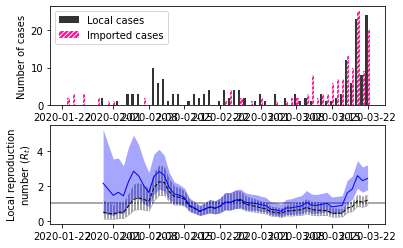

In [11]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
epsilon_range = [0.2, 1.0]

branchpro.figures.plot_regions_inference(
    datetime.datetime(2020, 1, 23),
    ['Hong Kong'],
    [locally_infected_cases],
    [imported_cases],
    datetime.datetime(2020, 1, 23) + datetime.timedelta(days=inference_times[0]-1),
    list(epsilon_range),
    [[all_intervals.loc[all_intervals['Epsilon']==eps] for eps in epsilon_range]],
    default_epsilon=1.0,
    show=False)

plt.savefig('HK_inference.pdf')

## Save mean Rt profile to file

In [ ]:
interval = all_intervals.loc[all_intervals['Epsilon']==1][['Time Points', 'Mean']]
interval.to_csv('../data_library/rt_profile/HK-Rt-profile.csv', sep=',', index=False)